In [ ]:
!pip install transformers

# Create Training Set

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

path = '/kaggle/input/tweets-dataset/tweets.csv'

# Load the dataset into a Pandas DataFrame
df = pd.read_csv(path)

# Print the first few rows of the DataFrame to verify the data
print(df.head())


# Cleaning the tweets


In [6]:
import pandas as pd
import re

# Example DataFrame
df = pd.DataFrame({'content': df['content']})

def clean_text(text):
    cleaned_text = re.sub(r'[^\w\s]', '', text)
    return cleaned_text

def remove_urls(text):
    cleaned_text = re.sub(r'http\S+|www\S+', '', text)
    return cleaned_text

def remove_mentions_hashtags(text):
    cleaned_text = re.sub(r'@\w+|#\w+', '', text)
    return cleaned_text

def lowercase_text(text):
    return text.lower()

# Applying the cleaning functions to the 'column' in the DataFrame
df['cleaned_column'] = df['content'].apply(clean_text)
df['cleaned_column'] = df['cleaned_column'].apply(remove_urls)
df['cleaned_column'] = df['cleaned_column'].apply(remove_mentions_hashtags)
df['cleaned_column'] = df['cleaned_column'].apply(lowercase_text)

print(df)


                                                 content  \
0      Is history repeating itself...?#DONTNORMALIZEH...   
1      @barackobama Thank you for your incredible gra...   
2                    Life goals. https://t.co/XIn1qKMKQl   
3                Me right now 🙏🏻 https://t.co/gW55C1wrwd   
4      SISTERS ARE DOIN' IT FOR THEMSELVES! 🙌🏻💪🏻❤️ ht...   
...                                                  ...   
52537               Life couldn't be better right now. 😊   
52538  First Monday back in action. I'd say 21.6 mile...   
52539  Crime shows, buddy, snuggles = the perfect Sun...   
52540                          ❄️ http://t.co/sHCFdPpGPa   
52541                      ❤️❄️✈️ http://t.co/ixmB5lv17Z   

                                          cleaned_column  
0          is history repeating itselfdontnormalizehate   
1      barackobama thank you for your incredible grac...  
2                                            life goals   
3                                         m

In [9]:
tweets = df['cleaned_column'].copy()
tweets.shape
tweets.head

<bound method NDFrame.head of 0            is history repeating itselfdontnormalizehate 
1        barackobama thank you for your incredible grac...
2                                              life goals 
3                                           me right now  
4                     sisters are doin it for themselves  
                               ...                        
52537                    life couldnt be better right now 
52538    first monday back in action id say 216 miles i...
52539    crime shows buddy snuggles  the perfect sunday...
52540                                                     
52541                                                     
Name: cleaned_column, Length: 52542, dtype: object>

# GPT2 Tokenizer

We will be using the GPT-2 tokenizer to tokenize our tweets. The defaults of this function set the bos (beginning of sentence) eos (end of sentence) to '<|endoftext|>' .

In [11]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token='<|startoftext|>', 
                                          eos_token='<|endoftext|>', 
                                          pad_token='<|pad|>')


tokenizer.encode("sisters are doin it for themselves ")

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


[82, 6223, 389, 466, 259, 340, 329, 2405, 220]

In [14]:
max_tweet = max([len(tokenizer.encode(tweet)) for tweet in tweets])

print(f'The longest tweet is {max_tweet} tokens long.')

The longest tweet is 113 tokens long.


# PyTorch Datasets & Dataloaders

In [15]:
bs = 16

We are  creating a custom dataloader for our corpus.

In [35]:
import torch
torch.manual_seed(42)
from torch.utils.data import Dataset # Importing the Dataset class from torch

class MTGDataset(Dataset):
    def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=max_tweet):
        self.tokenizer = tokenizer # Store the tokenizer object
        self.input_ids = [] # List to store input IDs
        self.attn_masks = [] # List to store attention masks

        for txt in txt_list:
            # Tokenize the text and generate encodings
            encodings_dict = tokenizer('' + txt + '', 
                                       truncation=True, 
                                       max_length=max_length, 
                                       padding="max_length")
            # Convert the encodings to tensors and append to the respective lists
            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
    def __len__(self):
        return len(self.input_ids) # Return the length of the dataset
    
    def __getitem__(self, idx):
        # Get the input ID and attention mask for a given index
        return self.input_ids[idx], self.attn_masks[idx]


# Split the data

In [21]:
from torch.utils.data import random_split

dataset = MTGDataset(tweets, tokenizer, max_length=max_tweet)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


# Create our dataloaders

In [22]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), # Sampling for training is random
            batch_size = bs
        )

validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), # Sampling for validation is sequential as the order doesn't matter.
            batch_size = bs 
        )

# Finetune GPT2 Language Model

In [23]:
import random
import torch
import numpy as np
from transformers import GPT2LMHeadModel, GPT2Config

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Set the seed for reproducibility
set_seed(42)

# Loading the model configuration and setting it to the GPT2 standard settings.
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# Create the instance of the model and set the token size embedding length
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model.resize_token_embeddings(len(tokenizer))

# Tell PyTorch to run this model on the GPU if available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): Laye

In [24]:
# We wil create a few variables to define the training parameters of the model
# epochs are the training rounds
# the warmup steps are steps at the start of training that are ignored
# every x steps we will sample the model to test the output

epochs = 4
warmup_steps = 1e2
sample_every = 100

We use AdamW optimizer for training, we will be using Hugging Face's implementation and all of it's defaults, we will also set the number of epochs here.

In [36]:
from transformers import AdamW
# AdamW is a class from the huggingface library, it is the optimizer we will be using, and 
# we will only be instantiating it with the default parameters. 

optimizer = AdamW(model.parameters(),
                  lr = 5e-4,
                  eps = 1e-8
                )

In [26]:
from transformers import get_linear_schedule_with_warmup

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [27]:
import random
import time
import datetime

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round(elapsed))))

total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(epochs):
    print(f'Beginning epoch {epoch_i + 1} of {epochs}')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(b_input_ids,
                        labels=b_labels,
                        attention_mask=b_masks,
                        token_type_ids=None)

        loss = outputs[0]
        loss.backward()

        optimizer.step()
        scheduler.step()

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every 100 batches.
        if step % sample_every == 0 and step != 0:
            elapsed = format_time(time.time() - t0)
            print(f'Batch {step} of {len(train_dataloader)}. Loss: {batch_loss}. Time: {elapsed}')

            model.eval()

            sample_outputs = model.generate(
                bos_token_id=random.randint(1, 30000),
                do_sample=True,
                top_k=50,
                max_length=200,
                top_p=0.95,
                num_return_sequences=1
            )

            for i, sample_output in enumerate(sample_outputs):
                print(f'Example output: {tokenizer.decode(sample_output, skip_special_tokens=True)}')

            model.train()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')

    t0 = time.time()

    model.eval()

    total_eval_loss = 0

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids,
                            attention_mask=b_masks,
                            labels=b_labels)

            loss = outputs[0]
            batch_loss = loss.item()
            total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)

    print(f'Validation loss: {avg_val_loss}. Validation Time: {validation_time}')

    # Record all statistics from this epoch.
    training_stats.append({
        'epoch': epoch_i + 1,
        'Training Loss': avg_train_loss,
        'Valid. Loss': avg_val_loss,
        'Training Time': training_time,
        'Validation Time': validation_time
    })

print(f'Total training took {format_time(time.time() - total_t0)}')


Beginning epoch 1 of 4


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 2956. Loss: 0.7920421957969666. Time: 0:00:28
Example output:  bipartisantweet you and my love to ya thank you for the love of my brother 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 2956. Loss: 0.8038670420646667. Time: 0:00:56
Example output:  increasingin a moment of truth and justice the world needs a president who is willing to truth and justice president obama


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 2956. Loss: 0.7909032106399536. Time: 0:01:24
Example output: dayand its getting warmer than the coldest on this year  


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 2956. Loss: 0.874513566493988. Time: 0:01:52
Example output:  Hangwishing yall a great day for all of you so glad everyone has been living up to their dreams 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 2956. Loss: 0.7690739631652832. Time: 0:02:19
Example output:  foodsyou have one year to give up something great youre free  


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 600 of 2956. Loss: 0.7968603372573853. Time: 0:02:47
Example output:  trailmy babies are going to be so excited and excited for the new year because they want to be on my favorite day in the year to be free and having free time to celebrate my new baby 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 700 of 2956. Loss: 0.651425302028656. Time: 0:03:15
Example output: intendthe president says climate change will not lead to dangerous climate change but may lead to a safer future 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 800 of 2956. Loss: 0.7226152420043945. Time: 0:03:43
Example output:  surroundshakski 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 900 of 2956. Loss: 0.6524945497512817. Time: 0:04:10
Example output:  reflexi think my first show last nights tour had a wonderful time too  love this song


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1000 of 2956. Loss: 0.8291040062904358. Time: 0:04:38
Example output:  displaythis is how the world is seeing president obama get ready to speak this at the gala 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1100 of 2956. Loss: 0.7360147833824158. Time: 0:05:06
Example output:  pastorthank you cbcr0w and jtimberlake all in person to all the lovely friends i had at cbs brianlegend thanks


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1200 of 2956. Loss: 0.71565181016922. Time: 0:05:33
Example output:  illicityou guys know that one song on itunesmusic you all got its so sweet thanks for all of the great interviews i do


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1300 of 2956. Loss: 0.8034420013427734. Time: 0:06:01
Example output:  Liberationawww this is true 
ts1989  


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1400 of 2956. Loss: 0.7136149406433105. Time: 0:06:29
Example output:  Nami love you 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1500 of 2956. Loss: 0.7057833075523376. Time: 0:06:56
Example output: IONmichael kurmsworths tweet was so fun this week he was so so excited i got to make him laugh and be funny for you luv it


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1600 of 2956. Loss: 0.888001561164856. Time: 0:07:24
Example output:  glimpsethis is crazy love you guys but if you think you can take care of me i will show you my love


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1700 of 2956. Loss: 0.8419660329818726. Time: 0:07:52
Example output:  Laurea world water crisis is unfolding in china the most likely scenario for dakota as a nation 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1800 of 2956. Loss: 0.7070287466049194. Time: 0:08:20
Example output: ismi love this 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1900 of 2956. Loss: 0.5178170800209045. Time: 0:08:47
Example output: ounthis tweet just sums it up  


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2000 of 2956. Loss: 0.7258792519569397. Time: 0:09:15
Example output:  electionkimoji i love you too yayo


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2100 of 2956. Loss: 0.7717195153236389. Time: 0:09:42
Example output:  crazyhey everybody who voted this will be in the biggest category of my vote vote me at 1pm   


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2200 of 2956. Loss: 0.8018632531166077. Time: 0:10:10
Example output:  benchlive president obama is hosting a town hall discussion on the economy 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2300 of 2956. Loss: 0.5615180134773254. Time: 0:10:38
Example output:  incorporatedi cant wait to share with you all some wonderful ideas for your next game        


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2400 of 2956. Loss: 0.7933300733566284. Time: 0:11:06
Example output: Peteri was thinking of making a double date tomorrow so excited to share my best of luck with my fans  


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2500 of 2956. Loss: 0.5343289375305176. Time: 0:11:33
Example output: uringhope you catch my new tnf game theres no internet at home


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2600 of 2956. Loss: 0.6601719260215759. Time: 0:12:01
Example output:  reproductivehappy halloween everyone 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2700 of 2956. Loss: 0.6682478189468384. Time: 0:12:29
Example output:  zonethe world has never seen something like my look 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2800 of 2956. Loss: 0.5757416486740112. Time: 0:12:56
Example output:  commitswhat we got is a perfect world for a limited time  


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2900 of 2956. Loss: 0.8553226590156555. Time: 0:13:24
Example output:  ironyjazzy  
Average Training Loss: 0.8081860053119866. Epoch time: 0:13:39
Validation loss: 0.6710622987305139. Validation Time: 0:00:29
Beginning epoch 2 of 4


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 2956. Loss: 0.6038457155227661. Time: 0:00:28
Example output:  Sahwe are on earth with the capacity to reach and understand our planet and to speak up for our children president obama 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 2956. Loss: 0.5896960496902466. Time: 0:00:56
Example output:  Bryandont miss jimgaffigan its an amazing performance by your nba super hero arianagrande amp another great surprise from ronaldo


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 2956. Loss: 0.6597603559494019. Time: 0:01:23
Example output:  spiritswishing so much to my brother peter and his family theyre really into my boy 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 2956. Loss: 1.100949764251709. Time: 0:01:51
Example output:  seesws are and the love and you of i tonight  tonight 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 2956. Loss: 1.1311763525009155. Time: 0:02:19
Example output:  hungrywhat me guys and love you are good so well we get you so to watch at a new day a good of the world 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 600 of 2956. Loss: 0.9860385060310364. Time: 0:02:47
Example output:  PTcongratulations for the big game tonight on to our friends and a lot of a big win against the real show tomorrow night thank you


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 700 of 2956. Loss: 0.5865582823753357. Time: 0:03:15
Example output: üyou guys know that video is incredible congrats guys u guys 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 800 of 2956. Loss: 0.7889037728309631. Time: 0:03:42
Example output: rucemichael jackson and i play 5 second rule at jtimberlake    fallontonight


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 900 of 2956. Loss: 0.7992479205131531. Time: 0:04:10
Example output:  derivativestune in at 1035 pm et to help children in need amp save the world a new foundation to help children in need 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1000 of 2956. Loss: 0.5950056910514832. Time: 0:04:38
Example output: thank you ryanseacrest for your love and support for my favorite album lyric video


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1100 of 2956. Loss: 0.5400579571723938. Time: 0:05:06
Example output:  rememberingthank you all for all your love  


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1200 of 2956. Loss: 0.7175599336624146. Time: 0:05:33
Example output:  Sourcesbts michael canson and kevinhart4real lol katyperry this is me


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1300 of 2956. Loss: 0.709887683391571. Time: 0:06:01


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example output: emsim on my app today and dont forget to send it with the ellens 
Batch 1400 of 2956. Loss: 0.6809934973716736. Time: 0:06:29
Example output: tzthis show was magical thank you bieberweek 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1500 of 2956. Loss: 0.7903153300285339. Time: 0:06:56
Example output: maticwhat is happening  


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1600 of 2956. Loss: 0.5284359455108643. Time: 0:07:24
Example output:  syndhappy birthday david 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1700 of 2956. Loss: 0.44343456625938416. Time: 0:07:51
Example output:  gamhappy birthday iamcol the most incredible writer and coolest songwriter ever we are all the same


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1800 of 2956. Loss: 0.6690139174461365. Time: 0:08:19
Example output:  injurylovetwitter 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1900 of 2956. Loss: 0.5572428107261658. Time: 0:08:47
Example output: azawatch the president deliver a statement on the importance of investing in education   


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2000 of 2956. Loss: 0.6464642882347107. Time: 0:09:15
Example output:  membranethe one person i have in my life who wants to be on the jb in the first few seconds is the real killer natalie portman


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2100 of 2956. Loss: 0.6222766637802124. Time: 0:09:42
Example output: ijingcongratulations china youre very welcome 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2200 of 2956. Loss: 0.7147567868232727. Time: 0:10:10
Example output:  castthe countdown to the holidays begins tomorrow at noon pst check your options for more 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2300 of 2956. Loss: 0.5555905103683472. Time: 0:10:38
Example output:  purchi want to dedicate my 7th birthday to my baby son  


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2400 of 2956. Loss: 0.5782933831214905. Time: 0:11:05
Example output:  shouldersthe president is delivering remarks about the latest steps in the fight for equalpayday 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2500 of 2956. Loss: 0.49700236320495605. Time: 0:11:33
Example output:  builtchaelinbieber xoxo


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2600 of 2956. Loss: 0.6168050169944763. Time: 0:12:01
Example output:  openlyi love you more than i love you


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2700 of 2956. Loss: 0.6801971197128296. Time: 0:12:28
Example output:  haltedthank you for the beautiful flowers and the beautiful flowers tonight see you soon  


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2800 of 2956. Loss: 0.7700589299201965. Time: 0:12:56
Example output:  Nikdiscovering the new twittercom


android 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2900 of 2956. Loss: 0.7166319489479065. Time: 0:13:24
Example output:  tinlovewins rihanna is officially the first 1 album on itunesmusic to reach 100 million views amp 7daystillbritneyjean
Average Training Loss: 0.7066397026927287. Epoch time: 0:13:39
Validation loss: 0.6605585183959601. Validation Time: 0:00:29
Beginning epoch 3 of 4


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 2956. Loss: 0.4723603129386902. Time: 0:00:28
Example output:  clinicallove katyperry i love her luv her britneyween cant wait for her premiere


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 2956. Loss: 0.6167806386947632. Time: 0:00:56
Example output: lectionskanyewest you are a talent i know i love this 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 2956. Loss: 0.5550564527511597. Time: 0:01:23
Example output: elsthank you so much for being so sweet 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 2956. Loss: 0.4784436821937561. Time: 0:01:51
Example output: labdavidbowie and jtimberlake are bringing on thehuntsmanprojuproast 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 2956. Loss: 0.5081786513328552. Time: 0:02:19
Example output:  tripledailyfluff
   


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 600 of 2956. Loss: 0.5798465013504028. Time: 0:02:46
Example output: 220just got this video from nmm last night was one of my fav moments of writing lyrics to songs on pop at the club thank you guys 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 700 of 2956. Loss: 0.6906189918518066. Time: 0:03:14
Example output:  Seeif you missed the live stream of the president at 9 pm et about to watch the full text here 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 800 of 2956. Loss: 0.5819932222366333. Time: 0:03:42
Example output: @@tried to surprise this man for a chance to meet him for his first grammy nomination  


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 900 of 2956. Loss: 0.5362088680267334. Time: 0:04:10
Example output:  hosti love her 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1000 of 2956. Loss: 0.4394434094429016. Time: 0:04:37
Example output: rolemysterwars thank you so much for your support


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1100 of 2956. Loss: 0.4970889687538147. Time: 0:05:05
Example output: iachappy bday to my brilliant friend tony and the other talented kids 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1200 of 2956. Loss: 0.6006761789321899. Time: 0:05:33
Example output:  LDthis is the game i need to win  rsvp  


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1300 of 2956. Loss: 0.6283989548683167. Time: 0:06:00
Example output:  Listenthank you all for supporting my cause i want to end the hate and injustice i have created for my brothers 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1400 of 2956. Loss: 0.6505513787269592. Time: 0:06:28
Example output:  dyhappy nationaltequiladay 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1500 of 2956. Loss: 0.539700448513031. Time: 0:06:56
Example output:  Domesticif u cant believe its the 13th and i think this is a breakthrough 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1600 of 2956. Loss: 0.41908136010169983. Time: 0:07:23
Example output:  beneficiarieslive now livestream on youtube tomorrow at 10am 
 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1700 of 2956. Loss: 0.7308722734451294. Time: 0:07:51
Example output:  Titlebritney and i get to do our best show to give you the illusion of being in love is up on the amas thank you so much


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1800 of 2956. Loss: 0.5833613276481628. Time: 0:08:19
Example output:  μcongrats to ronaldo carolina last year 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1900 of 2956. Loss: 0.5397288799285889. Time: 0:08:47
Example output:  sellingdont forget the rest of our love u will always be missed


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2000 of 2956. Loss: 0.566641628742218. Time: 0:09:14
Example output:  migrantbuzzfeed 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2100 of 2956. Loss: 0.4612511694431305. Time: 0:09:42
Example output: ivelyi see u lisbon jingleball so fucking cute


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2200 of 2956. Loss: 0.5408176183700562. Time: 0:10:10
Example output:  orderthe week on instagram  263
 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2300 of 2956. Loss: 0.4365348517894745. Time: 0:10:37
Example output:  VPNwatch president obama discuss ways hes taking action to improve access to betterbroadband 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2400 of 2956. Loss: 0.5770886540412903. Time: 0:11:05
Example output:  explanationwhat do you call your best friend


sounds right in your head
soundsright 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2500 of 2956. Loss: 0.5888460874557495. Time: 0:11:33
Example output:  Bachi want you to see this new video for i cant wait for you to hear it 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2600 of 2956. Loss: 0.43513062596321106. Time: 0:12:00
Example output:  folderdwyer_ you are so inspiring


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2700 of 2956. Loss: 0.45514556765556335. Time: 0:12:28
Example output:  buildingthe2020experience 2of2 track 7 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2800 of 2956. Loss: 0.5459794402122498. Time: 0:12:56
Example output:  Babyloni cant believe how proud i am of my friends so happy to win peoples choice award of the year for being nominated at the billboard music awards 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2900 of 2956. Loss: 0.4511784613132477. Time: 0:13:24
Example output: periali wish u had a more loving life together as a duo 
Average Training Loss: 0.5609984486710397. Epoch time: 0:13:39
Validation loss: 0.6518478385402077. Validation Time: 0:00:29
Beginning epoch 4 of 4


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 2956. Loss: 0.44489017128944397. Time: 0:00:28
Example output:  rentsjust posted a video 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 2956. Loss: 0.5034883618354797. Time: 0:00:55
Example output:  Regthe one amp only emmaisonnaison rt emmaisonnaisonn  thank you sweetie 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 2956. Loss: 0.5243139863014221. Time: 0:01:23
Example output: olasmabille_xo mb huh


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 2956. Loss: 0.5159496068954468. Time: 0:01:51
Example output:  responsestune in today at 215 pm et to watch president obama speak with childrensla at the nationalshumanvention watch here  shak


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 2956. Loss: 0.4858497679233551. Time: 0:02:19
Example output:  attendancei  a woman a dog a lion a tiger a koalas 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 600 of 2956. Loss: 0.4059762954711914. Time: 0:02:46
Example output:  rigidwhen it comes to a concertgo to the venue to see my face the energy is building and growing 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 700 of 2956. Loss: 0.5442848801612854. Time: 0:03:14
Example output: grocheck out the behind the scenes photos from the game in headsup 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 800 of 2956. Loss: 0.44103893637657166. Time: 0:03:42
Example output:  Greif theres a side by side of christmas like   find out how this past weekend will benefit from this christmasandchill 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 900 of 2956. Loss: 0.4661157727241516. Time: 0:04:10
Example output: uratonight on the show playing pyramid with the roots jasonsegel and amy sedaris stops by and music from g_eazy ft maluma fallontonight


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1000 of 2956. Loss: 0.3951621651649475. Time: 0:04:38
Example output:  2020hbd victoriamonet_  dont give up on yourself


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1100 of 2956. Loss: 0.49312710762023926. Time: 0:05:05
Example output:  chargingi dont believe in timetraveling cause we all live by nature fallonmono


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1200 of 2956. Loss: 0.3933274745941162. Time: 0:05:33
Example output:  Sartonight kristenmerlin jtimberlake music from the_dubbs and your funniest puppy predictors fallontonight


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1300 of 2956. Loss: 0.4368738532066345. Time: 0:06:01
Example output:  Jasthanks so much for all of the nice comments on my new look i was very happy the pieces are now in the ellen shop 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1400 of 2956. Loss: 0.3863675594329834. Time: 0:06:29
Example output:  permityou asked olá salúbado so how can you say you dont care after asking me  


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1500 of 2956. Loss: 0.5097678303718567. Time: 0:06:57
Example output:  Administratorits worldelephantday which day 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1600 of 2956. Loss: 0.4682605564594269. Time: 0:07:24
Example output:  EVENTShappy nmm send me your nomakeupmonday selfies 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1700 of 2956. Loss: 0.4069359004497528. Time: 0:07:52
Example output:  Mentalthis tour is about survival i wanted people who are willing to risk their lives on this extremely dangerous tour president obama on the 10th anniversary


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1800 of 2956. Loss: 0.45024731755256653. Time: 0:08:20
Example output: idsthank you to all the beliebers at kentucky who rescued me they gave me a ride or two to the red carpet that night


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1900 of 2956. Loss: 0.5236890912055969. Time: 0:08:48
Example output: ceansbae 
 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2000 of 2956. Loss: 0.4909493327140808. Time: 0:09:15
Example output:  geneticallythe2020experience 2of2 track 3
 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2100 of 2956. Loss: 0.44936609268188477. Time: 0:09:43
Example output:  adviceyou are so sweet thank you for helping so many people reach their dreams via glossyco 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2200 of 2956. Loss: 0.4775570333003998. Time: 0:10:11
Example output:  incompletelizakoshy yes do


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2300 of 2956. Loss: 0.6172742247581482. Time: 0:10:39
Example output: commentthis was one of my favorite covers i had done for my bank bes

this is all i got
a classic
cheek to cheek by taylor taylor


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2400 of 2956. Loss: 0.4874849319458008. Time: 0:11:07
Example output:  piloti will have it  


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2500 of 2956. Loss: 0.5378621816635132. Time: 0:11:34
Example output: gersdont miss your chance to meet president obama enter now   


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2600 of 2956. Loss: 0.4654245376586914. Time: 0:12:02
Example output:  mutationmy new single focus comes out in two days preorder it heregt   


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2700 of 2956. Loss: 0.4780579209327698. Time: 0:12:30
Example output:  Driverthis traveltuesday ill share some more stories to share with you via  traveltuesday 


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2800 of 2956. Loss: 0.5372265577316284. Time: 0:12:57
Example output: itihanging on my girl josephkahn ive officially been on a cross stella tour lol


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2900 of 2956. Loss: 0.40480855107307434. Time: 0:13:25
Example output: fffbts fotogames  
Average Training Loss: 0.4733721877527656. Epoch time: 0:13:40
Validation loss: 0.6673184179426327. Validation Time: 0:00:29
Total training took 0:56:34


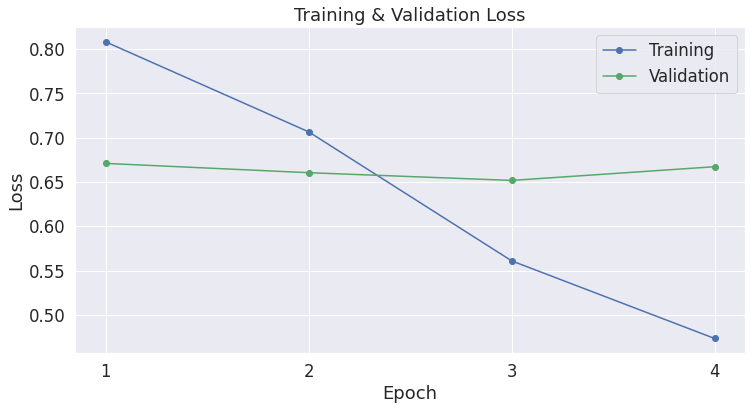

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert the training_stats list to a DataFrame
df_stats = pd.DataFrame(training_stats)

# Create a figure and axes for the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Use plot styling from seaborn
sns.set(style='darkgrid', font_scale=1.5)

# Plot the learning curve
ax.plot(df_stats['epoch'], df_stats['Training Loss'], 'b-o', label="Training")
ax.plot(df_stats['epoch'], df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot
ax.set_title("Training & Validation Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

# Set the x-axis ticks
ax.set_xticks(df_stats['epoch'])

# Show the plot
plt.show()


# Generate Text

In [30]:
model.eval()

prompt = "future"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
    print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: futureyou asked hi cristiano can you say hi dennis 


1: futureits now on the tinderallamerican app  get started today  teamjt


2: futurethe_pug im so proud of you this video is everything i love you i love youuuu 




